In [1]:
!pip install pymysql
!pip install pmdarima
!pip install plotly




In [10]:
import pymysql
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

_db = pymysql.connect(
    host="ls-a20f4420f7aa9967e25c1e0aecf4d8b641af5f13.cgtgapkuvqbt.ap-northeast-2.rds.amazonaws.com",
    db="stock",
    user = "dbmasteruser",
    password= "r,3Ipn|O7mL2vL4S)9Q~;7QVdHMV6R9j",
    port = 3306)

list_air = [ 'AK홀딩스_006840', '대한항공_003490', '아시아나항공_020560', '에어부산_298690', '제주항공_089590', '진에어_272450', '티웨이항공_091810', '티웨이홀딩스_004870']

for i in list_air:
    cursor = _db.cursor(pymysql.cursors.DictCursor)

    search_sql = f'SELECT * From {i}'

    cursor.execute(search_sql)            
    result = cursor.fetchall() 

    globals()[i] = pd.DataFrame(result)

<AxesSubplot:>

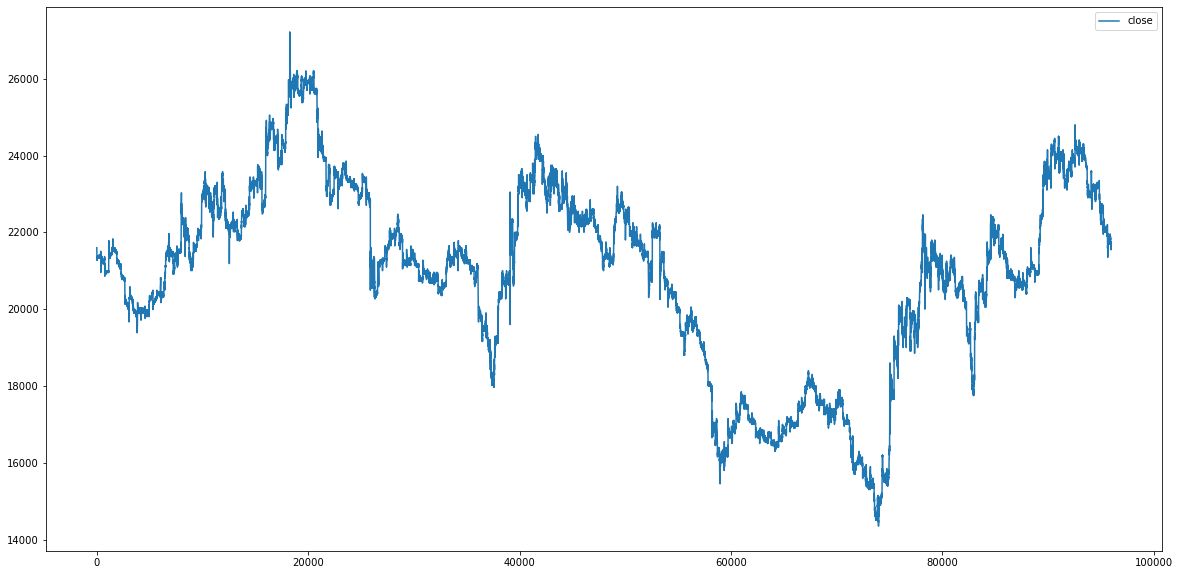

In [11]:
제주항공_089590[['close']].plot(figsize=(20,10))

<AxesSubplot:>

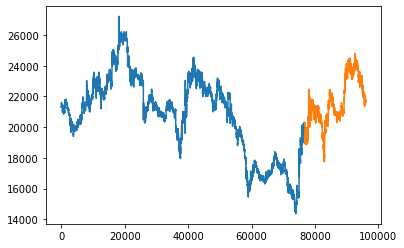

In [12]:
y_train=제주항공_089590['close'][:int(0.8*len(제주항공_089590))]
y_test = 제주항공_089590['close'][int(0.8*len(제주항공_089590)):]
y_train.plot(x='datetime', y='close')
y_test.plot(x='datetime', y='close')

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

In [14]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [15]:
model = pm.auto_arima(y = y_train,
                      d=1,
                      start_p=0,
                      max_p=3,
                      start_q=0,
                      max_q=3,
                      m=1,
                      seasonal=False,
                      stepwise=True,
                      trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=809469.712, Time=1.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=805592.861, Time=1.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=804876.203, Time=4.70 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=809467.723, Time=0.59 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=804574.410, Time=12.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=804545.814, Time=29.48 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=804871.670, Time=6.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=804537.775, Time=45.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=804721.821, Time=10.33 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=804533.350, Time=30.66 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=804541.153, Time=79.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=804535.088, Time=79.00 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=804535.925, Time=15.17 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=804531.370, Time=13.81 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                76783
Model:               SARIMAX(3, 1, 2)   Log Likelihood             -402259.685
Date:                Tue, 26 Apr 2022   AIC                         804531.370
Time:                        22:14:42   BIC                         804586.862
Sample:                             0   HQIC                        804548.413
                              - 76783                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1166      0.075     -1.549      0.121      -0.264       0.031
ar.L2          0.2672      0.026     10.458      0.000       0.217       0.317
ar.L3          0.0445      0.003     14.747      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


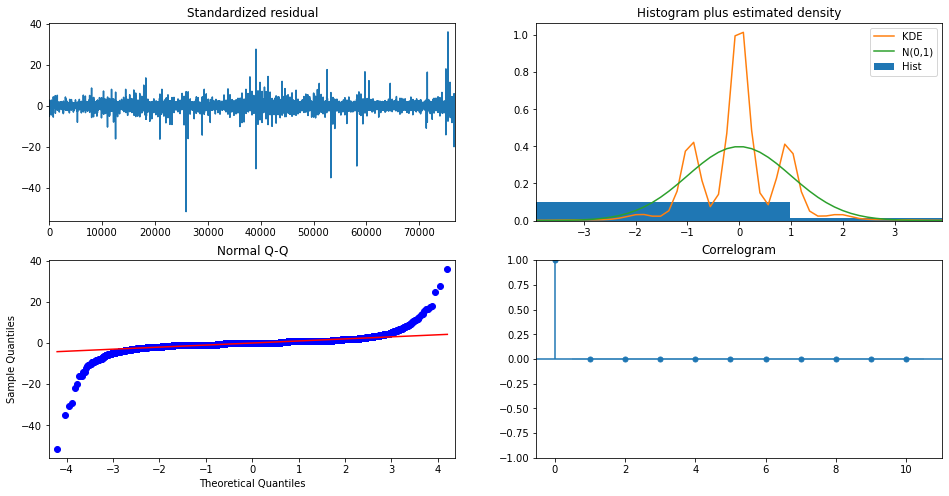

In [16]:
print(model.summary())
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [17]:
model.fit(y_train)

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

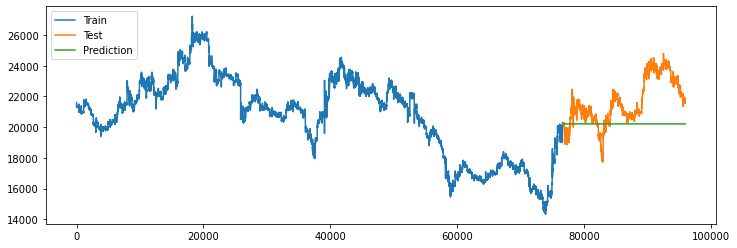

In [18]:
y_predict = model.predict(n_periods=len(y_test)) 
y_predict = pd.DataFrame(y_predict,index = y_test.index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [19]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [20]:
forecast_one_step()

(20208.86825345137, [20119.492760005916, 20298.24374689682])

In [21]:
forcast_list = []
y_pred = []
pred_upper = []
pred_lower = []

for i in y_test:
    fc , conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    
    model.update(i)

KeyboardInterrupt: 